In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from livelossplot.tf_keras import PlotLossesCallback
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import AutoTokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split 

import pickle

import numpy as np
import pandas as pd
from datetime import datetime 
import multiprocessing
import re
from bs4 import BeautifulSoup as bs
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import nltk
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

import matplotlib.pyplot as plt

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings("ignore") #, category=np.VisibleDeprecationWarning)

print(tf.__version__)

2.13.0


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# data = pd.read_csv('../datasets/spam.csv', encoding="cp1251", usecols=['v1', 'v2'])
# data.head()   

In [4]:
#READ DATA
# def read_train_data():
#     data = pd.read_csv('../datasets/spam.csv', encoding="cp1251", usecols=['v1', 'v2'])
#     mapping = {'ham': 0, 'spam': 1}
#     data.replace({'v1': mapping}, inplace=True)
#     data.rename(columns={"v1": "labels"}, inplace=True)
#     data.rename(columns={"v2": "raw_text"}, inplace=True)
# #     data.drop(['violation'], axis=1, inplace=True)
#     print('Data size %d' % len(data))
#     print('Data headers %s' % data.columns.values)
#     return data

In [5]:
# data = read_train_data()

In [6]:
# data.head()

In [7]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(neurons, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(0.5)
        self.dropout2 = Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [8]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Preprocessing function

In [9]:
# function to clean and pre-process the text.
def clean_text(text):  
    
    # 1. Removing html tags
    text = bs(text,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    text = re.sub("[^a-zA-Z]"," ", text)
    
    # 3. Converting to lower case and splitting
    word_tokens = text.lower().split()
    
    # 4. Remove stopwords
    le = WordNetLemmatizer()
    stop_words = set(stopwords.words("english")+ ['14000kbps', 'november', '1080p', 'email', 
                                                 '4k', 'mp4', 'error', '404', '2022', 'hd'])     
    word_tokens = [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review = " ".join(word_tokens)
    return cleaned_review

In [10]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [11]:
df_tra = pd.read_csv('../datasets/current_train_data.csv')
df_tra.head()

,time_spent_ms,raw_text,labels
0,100.0,"BIG LOADS, BRUNETTE, BIG DICKS, CUMSHOTS, PORN...",0
1,100.0,Crushed By Asian Ass MP4.mp4,0
2,100.0,Karol Arrives home and meet's Thatty on the so...,0
3,200.0,Karol Arrives home and meet's Thatty on the so...,0
4,100.0,Robbers Revenge WMV.wmv,0


In [12]:
# df = df_val[['text', 'labels']]

In [13]:
# df.head()

In [14]:
# df.labels.plot(kind='hist')

In [15]:
df_tra['text'] = df_tra.apply(lambda row: clean_text(row.raw_text), axis=1)

In [16]:
counter = counter_word(df_tra.text)  

In [17]:
counter['sex']

4739

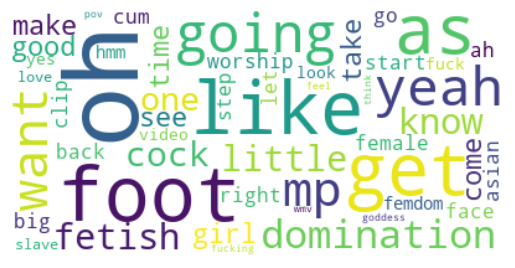

In [18]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [19]:
word_index =  dict()
for word, number in counter.items():
    word_index[word] = number + 3
    
word_index["<UNKNOWN>"] = 0
word_index["<FILLER>"] = 1
word_index["<BEGINOFSEQUENCE>"] = 2
word_index["<UNUSED>"] = 3

In [20]:
vocab_size = len(word_index)
oov_token = [k for k, v in word_index.items() if v == 0][0]
maxlen = 200

In [21]:
vocab_size

51181

In [22]:
from sklearn.utils import shuffle
RANDOM_STATE = 42

# df = shuffle(df, random_state=RANDOM_STATE).reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(df_tra.text.values, df_tra.labels.values, 
                                                  stratify=df_tra.labels.values, 
                                                  random_state=RANDOM_STATE, 
                                                  test_size=0.2, shuffle=True)

In [23]:
print(len(X_train), "Training sequences")
print(len(X_val), "Validation sequences")

96790 Training sequences
24198 Validation sequences


In [24]:
y_val[:5]

array([1, 0, 0, 0, 1])

In [25]:
# vectorize a text corpus by turning each text into sentence of integers

# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
# tokenizer.fit_on_texts(df_tra.text.values)

# # saving
# with open('../models/tokenizer_last.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('../models/tokenizer_last.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [26]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=maxlen)
X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(X_val_sequences, maxlen=maxlen)

# Build Model

In [27]:
embed_dim = 50  # 50 Embedding size for each token 32
num_heads = 7  # Number of attention heads default value 2
neurons = 100 #32 # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, num_heads, neurons)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.50)(x) # .35
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddi  (None, 200, 50)           2569050   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_encoder (Trans  (None, 200, 50)           81450     
 formerEncoder)                                                  
                                                                 
 global_average_pooling1d (  (None, 50)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 50)                0   

In [28]:
# draw model
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
lr = 1e-5
epochs = 25

loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.legacy.Adam(learning_rate=lr) #.000001)
metrics = ['accuracy']

# metrics = [tf.keras.metrics.BinaryAccuracy(),
#            tf.keras.metrics.FalseNegatives(),
#            tf.keras.metrics.FalsePositives(),
#           ]

# from pathlib import Path

# path = Path('../models/bad_words/trans/')
# path.mkdir(exist_ok=True) 
# cpt_filename = '{epoch:02d}_checkpoint_{val_loss:.2f}.hdf5'
# cpt_path = str(path / cpt_filename)

# checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=2, 
#                                                 save_best_only=True, mode='min')

# model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


# history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=32, validation_data=(X_val_padded, y_val), verbose=1, 
#            callbacks=[checkpoint, PlotLossesCallback()])
          
# # history = model.fit(X_train_padded, y_train, 
# #                     batch_size=64, epochs=10, 
# #                     validation_data=(X_val_padded, y_val)
#                    )

In [30]:
model_name = "../models/trans/trans_model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_padded, y_train,
                    validation_data=(X_val_padded,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])
model.summary()

Epoch 1/25
3025/3025 [==============================] - 480s 158ms/step - loss: 0.1437 - accuracy: 0.9455 - val_loss: 0.0565 - val_accuracy: 0.9824
Epoch 2/25
3025/3025 [==============================] - 472s 156ms/step - loss: 0.0355 - accuracy: 0.9890 - val_loss: 0.0465 - val_accuracy: 0.9866
Epoch 3/25
3025/3025 [==============================] - 467s 155ms/step - loss: 0.0197 - accuracy: 0.9941 - val_loss: 0.0513 - val_accuracy: 0.9871
Epoch 3: early stopping
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddi  (None, 200, 50)           2569050   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                     

In [31]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

,loss,accuracy,val_loss,val_accuracy
0,0.143673,0.945511,0.056482,0.982437
1,0.035524,0.988997,0.046480,0.986569
2,0.019743,0.994070,0.051312,0.987148


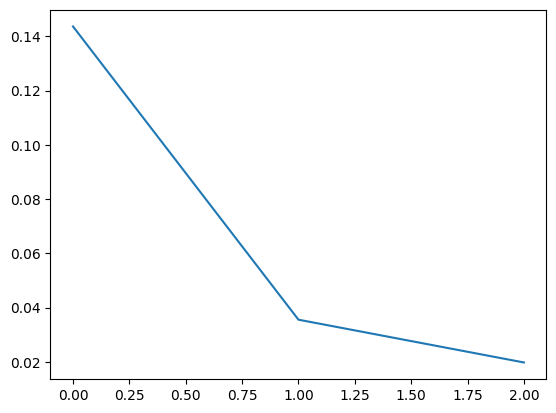

In [32]:
plt.plot(history_df.loss);

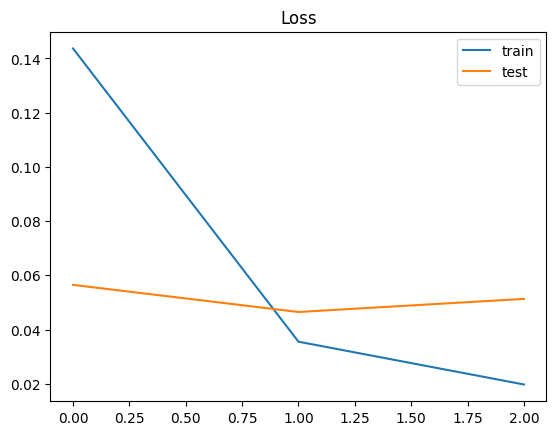

In [33]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

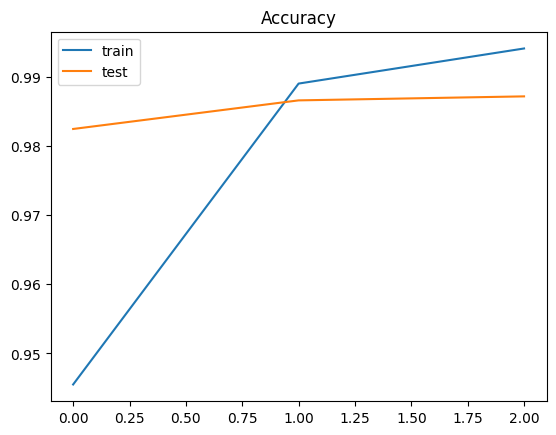

In [34]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

757/757 [==============================] - 44s 57ms/step


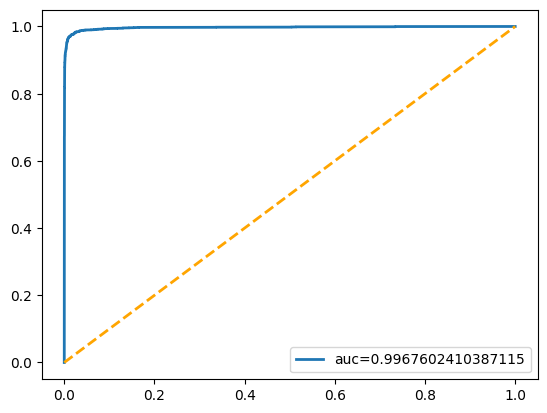

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

y_pred = model.predict(X_val_padded)
fpr, tpr, _ = roc_curve(y_val,  y_pred)
auc = roc_auc_score(y_val, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [36]:
y_pred = [1 if p > .5 else 0 for p in y_pred]

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20544
           1       0.95      0.97      0.96      3654

    accuracy                           0.99     24198
   macro avg       0.97      0.98      0.98     24198
weighted avg       0.99      0.99      0.99     24198



<Axes: >

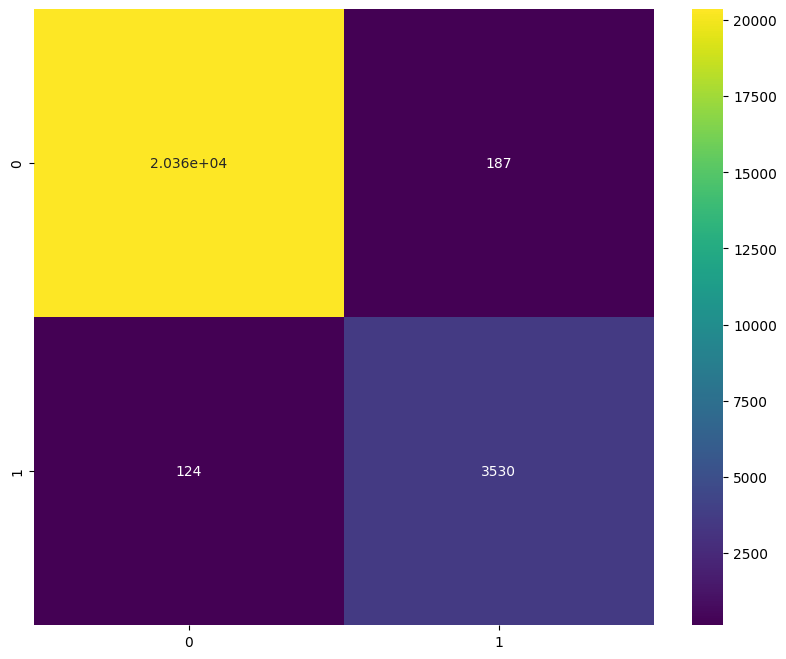

In [37]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_val, y_pred),annot=True,fmt='.4g',cmap='viridis')

In [38]:
results = model.evaluate(X_val_padded, y_val, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

757/757 - 50s - loss: 0.0513 - accuracy: 0.9871 - 50s/epoch - 65ms/step
loss: 0.051
accuracy: 0.987


In [39]:
predictions = model.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]
predictions

3025/3025 [==============================] - 173s 57ms/step


[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,


In [40]:
df_sequences = tokenizer.texts_to_sequences(df_tra.text)
df_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(df_sequences, maxlen=maxlen)

predictions = model.predict(df_sequences_padded)
predictions = [1 if p > .5 else 0 for p in predictions]
predictions

df_tra['predicted'] = predictions
df_tra = df_tra[['time_spent_ms', 'text', 'labels', 'predicted']]
df_tra.head()

3781/3781 [==============================] - 215s 57ms/step


,time_spent_ms,text,labels,predicted
0,100.0,big load brunette big dick cumshots pornstars ...,0,0
1,100.0,crushed asian as mp mp,0,0
2,100.0,karol arrives home meet thatty sofa wating tha...,0,0
3,200.0,karol arrives home meet thatty sofa wating tha...,0,0
4,100.0,robber revenge wmv wmv,0,0


In [41]:
df_tra.to_csv('../datasets/acc_989_model.csv')

In [42]:
def roc_auc(predictions, target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [43]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

scott young adam tied milking table force surrender semen sample measure size deliberately take time stroking cock massaging ball determined work big load adam quickly responds cock becomes hard breathing labored muscle tense scott work edge three time stop walk away leaving poor adam cool erection subside adam gasp tremble thrust hip scott tease load adam arch back gasp surrender sample waiting container lay breathless panting trying recover
[580, 178, 2145, 128, 872, 424, 555, 1257, 2673, 2800, 2127, 348, 10961, 22, 20, 303, 15, 2042, 70, 1723, 121, 30, 198, 2145, 597, 3410, 15, 905, 55, 753, 2980, 317, 2770, 580, 121, 271, 336, 20, 152, 358, 183, 747, 445, 2145, 939, 1488, 10587, 2145, 1125, 3761, 1002, 674, 580, 88, 198, 2145, 1139, 32, 1125, 1257, 2800, 544, 8902, 575, 2610, 1972, 282, 4195]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0    

In [44]:
# model.save_weights("../models/trans/trans_badwords_weights.h5")
# model.load_weights("../models/trans/trans_badwords_weights.h5") # loading weights - model had created erlier

In [45]:
# model.save('../models/trans/trans_badwords_model.h5')
# model = tf.keras.models.load_model("../models/trans/trans_badwords_model.h5")
# model.trainable = False # замораживаем базовую модель

In [46]:
df_val = pd.read_csv('../datasets/bw/BadWordsService_ml_has.csv')

In [47]:
df_val.drop('@timestamp', axis=1, inplace=True)
df_val['ctxt_.time_spent'] = df_val['ctxt_.time_spent'] * 1000 # convert seconds to milliseconds

In [48]:
df_val.rename(columns={"ctxt_.text": "raw_text"}, inplace=True)
df_val.rename(columns={"ctxt_.time_spent": "time_spent_ms"}, inplace=True)

In [49]:
df_val.head()

,time_spent_ms,raw_text
0,600.0,"<p>We're in detention together, me the slutty ..."
1,900.0,<p><p>It is a twilit night and I'm pursuing my...
2,800.0,"<p>I found lol*ta porn on your laptop, Step-Da..."
3,900.0,<p>I love getting presents from my loyal follo...
4,900.0,"<p>We're in detention together, me the slutty ..."


In [50]:
nan_values = df_val[df_val.isna().any(axis=1)]
print(len(nan_values))

0


In [51]:
df_val['text'] = df_val.apply(lambda row: clean_text(row.raw_text), axis=1)

In [52]:
df_val.drop('raw_text', axis=1, inplace=True)
df_val.head()

,time_spent_ms,text
0,600.0,detention together slutty brat always trouble ...
1,900.0,twilit night pursuing prey lovely tall lost wo...
2,800.0,found lol ta porn laptop step daddy big troubl...
3,900.0,love getting present loyal follower black red ...
4,900.0,detention together slutty brat always trouble ...


In [53]:
######## new
import itertools as itt
chunksize = 200
    
# vectorize a text corpus by turning each text into sentence of integers
max_len = 200
# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
# tokenizer.fit_on_texts(df_val['text'])


values = []
columns = ['text', 'time_elapsed_ms','label']
for index, elem in enumerate(df_val.text):
    start_time = datetime.now() 
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(elem, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
#     print(test_text_np)
#     print('LEN', len(test_text_np))
#     print('test_sequences', test_sequences)
#     print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
  

    tf.config.run_functions_eagerly(True)
    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (ms) {}'.format(time_elapsed.microseconds/1000))
#     print('Prediction:', max(predictions))
    if elem not in values:
#         print('**************', index, '~~~~~~~~~~~', elem, values[index-1])
        values.append([elem, round(time_elapsed.microseconds/1000, 1), max(predictions)])
        values[index][1] += round(time_elapsed.microseconds/1000, 1)
#         print('**************', index, '~~~~~~~~~~~', elem, '################', values[index][1])
df_result = pd.DataFrame(data=values, columns=columns)
########
# test_text_np = np.array([test_text_preprocessed])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)

1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 24ms/step


2/2 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 40ms/step


In [54]:
# del(df_result)
df_result.head()

,text,time_elapsed_ms,label
0,detention together slutty brat always trouble ...,606.6,0
1,twilit night pursuing prey lovely tall lost wo...,295.4,1
2,found lol ta porn laptop step daddy big troubl...,130.6,1
3,love getting present loyal follower black red ...,496.2,0
4,detention together slutty brat always trouble ...,122.2,0


In [55]:
df_val.head()

,time_spent_ms,text
0,600.0,detention together slutty brat always trouble ...
1,900.0,twilit night pursuing prey lovely tall lost wo...
2,800.0,found lol ta porn laptop step daddy big troubl...
3,900.0,love getting present loyal follower black red ...
4,900.0,detention together slutty brat always trouble ...


In [56]:
df_united = df_val.merge(df_result, right_on='text', left_on='text')
df_united['time_delta'] = df_united.time_spent_ms - df_united.time_elapsed_ms
df_united = df_united[['text', 'time_spent_ms', 'time_elapsed_ms', 'time_delta', 'label']]
df_united.drop_duplicates(['text'], keep='last', ignore_index=True, inplace=True)

In [57]:
df_united.head(20)

,text,time_spent_ms,time_elapsed_ms,time_delta,label
0,detention together slutty brat always trouble ...,900.0,136.8,763.2,1
1,twilit night pursuing prey lovely tall lost wo...,800.0,147.4,652.6,1
2,found lol ta porn laptop step daddy big troubl...,600.0,138.6,461.4,0
3,love getting present loyal follower black red ...,900.0,134.8,765.2,1
4,want foot slave say dream coming lovely foot w...,600.0,144.6,455.4,1
5,originally custom video production scroll info...,300.0,139.4,160.6,1
6,bless anima sd mp,100.0,147.6,-47.6,0
7,bless anima sd wmv,0.0,130.8,-130.8,0
8,eye fetish clip start playful get intense domi...,600.0,137.4,462.6,1
9,start end text got treat look even hard yet go...,900.0,286.4,613.6,1


In [58]:
df_united.to_csv('../datasets/trans_pred_999.csv', index=False)

In [62]:
######## new
import itertools as itt
chunksize = 200
max_len = chunksize

# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
# tokenizer.fit_on_texts(df_tra['text'])

# raw_text = """<p>You and your wife come home from yet another failed date night. You guys pay me every weekend to watch your annoying son. I inform your wife that yall&rsquo;s son has been in his room playing video games all day and that I don&rsquo;t get paid enough to help him with his homework. Your wife goes up to his room to help your son. Once I and you are alone, I tell you how I really want to fuck you, and that I know you want to fuck me too. You secretly text me telling me all the things you want to do to my young little fertile pussy, and you told me that you would love to see my body. I can see you&rsquo;re nervous about cheating on your wife, so I persuade you by undressing in front of you. I show you my wet pussy, and my huge tits and your cock is throbbing because you can&rsquo;t resist me. I begin giving your sloppy head, and eventually, I titty-fuck your cock, both POV style. I tell you that I always get what I want and that I have wanted to fuck you ever since I began working for you. I also tell you that I know your wife doesn&rsquo;t appreciate you paying all the bills and taking care of her, so I want to make up for that. Once I am done titty-fucking your cock, you go to pull out a condom to fuck me. I tell you that we aren&rsquo;t going to use a condom, even though I know I am not on birth control, because I want you to fill up my fertile pussy with your cum. I ride you and you fuck me from the side until you can&rsquo;t help but creampie me.</p>"""
# raw_text = """<p>You and your wife come home from yet another failed date night. You guys pay me every weekend to watch your annoying son. I inform your wife that yall&rsquo;s son has been in his room playing video games all day and that I don&rsquo;t get paid enough to help him with his homework. Your wife goes up to his room to help your son. Once I and you are alone, I tell you how I really want to fuck you, and that I know you want to fuck me too. You secretly text me telling me all the things you want to do to my young little fertile pussy, and you told me that you would love to see my body. I can see you&rsquo;re nervous about cheating on your wife, so I persuade you by undressing in front of you. I show you my wet pussy, and my huge tits and your cock is throbbing because you can&rsquo;t resist me. I begin giving your sloppy head, and eventually, I titty-fuck your cock, both POV style. I tell you that I always get what I want and that I have wanted to fuck you ever since I began working for you. I also tell you that I know your wife doesn&rsquo;t appreciate you paying all the bills and taking care of her, so I want to make up for that. Once I am done titty-fucking your cock, you go to pull out a condom to fuck me. I tell you that we aren&rsquo;t going to use a condom, even though I know I am not on birth control, because I want you to fill up my fertile pussy with your cum. I ride you and you fuck me from the side until you can&rsquo;t help but creampie me.</p>"""
# raw_text = """start end text getting started sweetheart going get information going think anything going torture going talk going talk say wait wait done sensitive love torturing torturing oh god sexy oh god much love teasing going get talk frankly enjoying every moment never work say torment pleasure going painful good feel take oh sticky going able resist torment oh yes much fun resist going resist oh feel shaking torment hard crazy oh god oh yes good love torturing feel good oh god sweet torture oh god think like torture torturing beautiful body bring height pleasure take able make anything able make tell anything want anything really get anything going get oh god oh god oh yes oh torture oh yes pure torture oh yes oh yes oh yes oh yes resist oh go slow torture oh god good know oh god oh yes oh yes oh yes oh mine play oh yes anything want anything yeah bring entire body life tantalizing teasing oh oh yes oh able resist hurting hard oh god much longer good oh let taste sweet oh bug god oh hard going tell still going tell oh okay get oh going torture love torturing take care take care take care take care oh yes oh god oh god terrible oh yes oh sorry oh yes pleasure oh fun torturing oh teasing oh yes taking right edge close oh god become going tell oh going tell oh close oh daytime oh god oh god fine teasing good love teasing torturing breathe know going come oh know know oh expert torture oh yeah oh mm hmm oh mm hmm oh god oh god glad going come want come wow always leave leave let come oh fine really torturing way please going come oh please think going oh yes since get information leaving torture tormenting okay talk tell want know coming okay coming coming coming coming oh fuck coming touch oh oh yeah like hmmm hmmm hmmm hmm uh uh uh uh hmmm going tell everything yeah yes oh oh oh oh broke torture mm hmm good yeah taste amazing love torturing torturing please okay mm hmm"""
raw_text = """<br></br>  This is the 640x360     version of  Jazmine aka Hannah Perez back for more clip four  : Limp, naked and played with    <br></br>Hannah has no idea where she is and who the stranger in front of her is. Needless to say, she is confused and tries to find out what happened to her but before she knows what hits her, she feels the guys hand on her throat and... her sexy young body wobbles and she slowly goes down while her eyes roll and flicker to the last second.     <br></br>Enjoy a very hot limp/rest segment. Like I mentioned this clip is all about our sleeepy girl being slowly moved, posed, dropped and other wise manipulated while out. Of course we take our time (and zoom in) while checking  her pussy, ass,  eyes, ears, hands, navel, remove her shoes, feet and so much more. Eye checks of course as well.  <br></br>HAND AND WRIST LIMPING, SEVERAL HAND AND LEG DROPS, FACE, RAGDOLLING, BODY LIMPING, PULLS, HEAD DROP"""
test_text_preprocessed = [clean_text(raw_text)]
print(test_text_preprocessed)
values = []
columns = ['text', 'time_elapsed_ms','label']
for index, elem in enumerate(test_text_preprocessed):
    start_time = datetime.now() 
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(elem, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
#     print(test_text_np)
#     print('LEN', len(test_text_np))
#     print('test_sequences', test_sequences)
#     print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
  

    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (ms) {}'.format(time_elapsed.microseconds/1000))
#     print('Prediction:', max(predictions))
    if elem not in values:
#         print('**************', index, '~~~~~~~~~~~', elem, values[index-1])
        values.append([elem, round(time_elapsed.microseconds/1000, 1), max(predictions)]) #max(predictions)
        values[index][1] += round(time_elapsed.microseconds/1000, 1)
#         print('**************', index, '~~~~~~~~~~~', elem, '################', values[index][1])
df_result = pd.DataFrame(data=values, columns=columns)
df_result

['x version jazmine aka hannah perez back clip four limp naked played hannah idea stranger front needle say confused try find happened know hit feel guy hand throat sexy young body wobble slowly go eye roll flicker last second enjoy hot limp rest segment like mentioned clip sleeepy girl slowly moved posed dropped wise manipulated course take time zoom checking pussy as eye ear hand navel remove shoe foot much eye check course well hand wrist limping several hand leg drop face ragdolling body limping pull head drop']
1/1 [==============================] - 0s 70ms/step


,text,time_elapsed_ms,label
0,x version jazmine aka hannah perez back clip f...,273.4,1


In [60]:
# def decode(sequence):
#     return " ".join([rvi.get(idx, "?") for idx in sequence])

# decoded_text = decode(X_train_sequences[10])

# print(X_train_sequences[10])
# print(decoded_text)